# Bootcamp Match 2
## NLP with Neural Network

# Import Libraries
Library yang dipakai adalah library data science standar dan keras untuk deep learning.

In [ ]:
!pip install -q PySastrawi
!pip install -q -U "tensorflow-text==2.8.*"

     |████████████████████████████████| 3.8 MB 5.4 MB/s 
     |████████████████████████████████| 596 kB 47.4 MB/s 
     |████████████████████████████████| 67 kB 5.2 MB/s 
     |████████████████████████████████| 6.5 MB 26.4 MB/s 
     |████████████████████████████████| 895 kB 46.8 MB/s 
     |████████████████████████████████| 210 kB 5.6 MB/s 
     |████████████████████████████████| 4.9 MB 5.6 MB/s 
     |████████████████████████████████| 462 kB 39.7 MB/s 


In [ ]:
# Standar Library
import re
import string

# Third-party Library
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import keras
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
import tensorflow as tf
import tensorflow_text as text
from tensorflow_text.tools.wordpiece_vocab import bert_vocab_from_dataset as bert_vocab
from transformers import pipeline
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from Sastrawi.Stemmer.StemmerFactory import StemmerFactory

pd.set_option("display.max_colwidth", 1000)

# Analisis Sentimen
merupakan task untuk memprediksi sentimen dari sebuah tulisan. Data yang digunakan sama seperti kemarin, yaitu review penyedia jaringan seluler.

Setelah melihat prosesnya, teman-teman boleh latihan lagi menggunakan data yang lain.

## Data Collections
Data yang kita gunakan adalah review dari sebuah penginapan.

In [ ]:
!git clone https://github.com/rakkaalhazimi/Data-NLP-Bahasa-Indonesia.git

Cloning into 'Data-NLP-Bahasa-Indonesia'...
remote: Enumerating objects: 32, done.
remote: Counting objects: 100% (32/32), done.
remote: Compressing objects: 100% (28/28), done.
remote: Total 32 (delta 7), reused 12 (delta 2), pack-reused 0
Unpacking objects: 100% (32/32), done.


In [ ]:
df = pd.read_csv("/content/Data-NLP-Bahasa-Indonesia/dataset_tweet_sentiment_cellular_service_provider.csv")
df.head()

,Id,Sentiment,Text Tweet
0,1,positive,<USER_MENTION> #BOIKOT_<PROVIDER_NAME> Gunakan Produk Bangsa Sendiri <PROVIDER_NAME>
1,2,positive,"Saktinya balik lagi, alhamdulillah :v <PROVIDER_NAME>"
2,3,negative,Selamat pagi <PROVIDER_NAME> bisa bantu kenapa di dalam kamar sinyal 4G hilang yang 1 lagi panggilan darurat saja <URL>
3,4,negative,Dear <PROVIDER_NAME> akhir2 ini jaringan data lemot banget padahal H+ !!!!
4,5,negative,Selamat malam PENDUSTA <PROVIDER_NAME>


## Text Preprocessing
Review pasti datang dengan format dan penulisan yang berbeda-beda, maka dari itu kita perlu menyusun sistem untuk merapikan dan membersihkan teks dalam review-review tersebut.

### Text Cleaning
Secara spesifik, hal yang akan kita lakukan adalah:
1. Pengubahan beberapa tanda baca menjadi spasi.
2. Reduksi spasi yang berlebihan menjadi satu spasi.
3. Penyamaan huruf besar dan kecil.

In [ ]:
punctuations = re.sub(r"[!<_>#:)\.]", "", string.punctuation)

def punct2wspace(text):
    return re.sub(r"[{}]+".format(punctuations), " ", text)

def normalize_wspace(text):
    return re.sub(r"\s+", " ", text)

def casefolding(text):
    return text.lower()

In [ ]:
# create stemmer
factory = StemmerFactory()
stemmer = factory.create_stemmer()

# stemming process
sentence = "Perekonomian Indonesia sedang dalam pertumbuhan yang membanggakan"
output   = stemmer.stem(sentence)

print(output)
# ekonomi indonesia sedang dalam tumbuh yang bangga

print(stemmer.stem("Mereka meniru-nirukannya"))

ekonomi indonesia sedang dalam tumbuh yang bangga
mereka tiru


### Preprocess

In [ ]:
def preprocess_text(text):
    text = punct2wspace(text)
    text = normalize_wspace(text)
    text = casefolding(text)
    # text = stemmer.stem(text)
    return text

preprocess_text("rakka@alhazimi")

'rakka alhazimi'

In [ ]:
# Ilustrasi teks yang sudah dibersihkan
df["cleaned_text"] = df["Text Tweet"].apply(preprocess_text)
df.head()

,Id,Sentiment,Text Tweet,cleaned_text
0,1,positive,<USER_MENTION> #BOIKOT_<PROVIDER_NAME> Gunakan Produk Bangsa Sendiri <PROVIDER_NAME>,<user_mention> #boikot_<provider_name> gunakan produk bangsa sendiri <provider_name>
1,2,positive,"Saktinya balik lagi, alhamdulillah :v <PROVIDER_NAME>",saktinya balik lagi alhamdulillah :v <provider_name>
2,3,negative,Selamat pagi <PROVIDER_NAME> bisa bantu kenapa di dalam kamar sinyal 4G hilang yang 1 lagi panggilan darurat saja <URL>,selamat pagi <provider_name> bisa bantu kenapa di dalam kamar sinyal 4g hilang yang 1 lagi panggilan darurat saja <url>
3,4,negative,Dear <PROVIDER_NAME> akhir2 ini jaringan data lemot banget padahal H+ !!!!,dear <provider_name> akhir2 ini jaringan data lemot banget padahal h !!!!
4,5,negative,Selamat malam PENDUSTA <PROVIDER_NAME>,selamat malam pendusta <provider_name>


### Dapatkan text dan label

In [ ]:
target = df["Sentiment"].map({"positive": 1, "negative": 0})
features_text = df["cleaned_text"]

## Input Pipeline
Berbeda dengan machine learning pada umumnya, kita perlu mengubah data teks ke bentuk vektor yang berisikan token ID masing-masing kata. 

Jadi jika ada kata "saya suka python" maka kata tersebut akan diubah menjadi [2, 0, 1], apabila kosa kata terdiri dari 0: suka, 1: python dan 2: saya.

### Split Data

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(features_text, target, random_state=42)

### Tf Dataset

In [ ]:
BATCH_SIZE = 32

In [ ]:
# Ubah input menjadi objek tf.data.Dataset
train_dataset = tf.data.Dataset.from_tensor_slices((X_train, y_train))
test_dataset = tf.data.Dataset.from_tensor_slices((X_test, y_test))

# Terapkan shuffle, batch dan prefetch pada dataset
train_dataset = train_dataset.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
test_dataset = test_dataset.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

In [ ]:
# Melihat isi dataset
for feat, tar in train_dataset.take(1):
    print(feat[:3])
    print(tar[:3])

tf.Tensor(
[b'<provider_name> hancur jaringannya'
 b'webnya <provider_name> dibajak ya cie dibajak semoga habis ini paket2 spam2 dan promo2nya makin subur <provider_name>'
 b'ini prinsip soalnya <provider_name> lebih murah dari <provider_name> masalah sinyal disini alhamdulillah kencang karena di kota besar kok'], shape=(3,), dtype=string)
tf.Tensor([0 0 1], shape=(3,), dtype=int64)


### Text Encoder

In [ ]:
max_features = 10000      # Jumlah kosakata
embedding_dim = 16        # Jumlah dimensi dalam word embedding

In [ ]:
# Buat text vectorizer
encoder = keras.layers.TextVectorization(max_tokens=max_features)

# Latih tokenizer pada data teks
encoder.adapt(train_dataset.map(lambda feat, tar: feat))

In [ ]:
# Tokenisasi data teks
encoder(feat)[:3]

<tf.Tensor: shape=(3, 20), dtype=int64, numpy=
array([[  2, 283, 172,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0],
       [319,   2, 294,  28, 762, 294, 142,  63,  11, 488, 385,  21, 461,
         20, 381,   2,   0,   0,   0,   0],
       [ 11, 463, 388,   2,  43,  61,  13,   2, 266,   9,  92,  38, 119,
         30,   3,  87, 298,  48,   0,   0]])>

## Model Building: Neural Network

### Bangun Model

In [ ]:
# Buat model sequential (berurutan)
model = keras.Sequential()
model.add(encoder)
model.add(keras.layers.Embedding(
    input_dim=len(encoder.get_vocabulary()), 
    output_dim=embedding_dim, 
    mask_zero=True)
)
model.add(keras.layers.LSTM(16, return_sequences=True))
model.add(keras.layers.LSTM(16))
model.add(keras.layers.Dropout(0.5))
model.add(keras.layers.Dense(8))
model.add(keras.layers.Dense(1, activation="sigmoid"))

# Tentukan loss, optimizer dan metrik yang akan digunakan
model.compile(loss="binary_crossentropy", 
              optimizer="rmsprop",
              metrics=["acc"])

### Struktur Model

In [ ]:
# Melihat arsitektur model
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 text_vectorization (TextVec  (None, None)             0         
 torization)                                                     
                                                                 
 embedding_3 (Embedding)     (None, None, 16)          13856     
                                                                 
 lstm_4 (LSTM)               (None, None, 16)          2112      
                                                                 
 lstm_5 (LSTM)               (None, 16)                2112      
                                                                 
 dropout_2 (Dropout)         (None, 16)                0         
                                                                 
 dense_4 (Dense)             (None, 8)                 136       
                                                      

### Bentuk Model

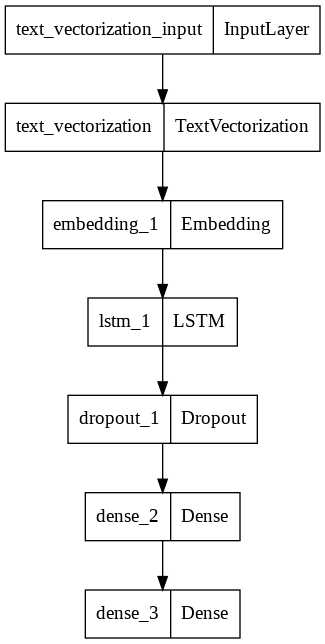

In [ ]:
# Melihat Diagram Model
keras.utils.vis_utils.plot_model(model, "model.png")

### Latih Model

In [ ]:
# Melatih model
history = model.fit(train_dataset,
                    epochs=10,
                    validation_data=test_dataset)

Epoch 1/10
8/8 [==============================] - 16s 440ms/step - loss: 0.6939 - acc: 0.4978 - val_loss: 0.6920 - val_acc: 0.6133
Epoch 2/10
8/8 [==============================] - 0s 33ms/step - loss: 0.6894 - acc: 0.6489 - val_loss: 0.6900 - val_acc: 0.7467
Epoch 3/10
8/8 [==============================] - 0s 34ms/step - loss: 0.6853 - acc: 0.7156 - val_loss: 0.6888 - val_acc: 0.6667
Epoch 4/10
8/8 [==============================] - 0s 26ms/step - loss: 0.6797 - acc: 0.7733 - val_loss: 0.6857 - val_acc: 0.6000
Epoch 5/10
8/8 [==============================] - 0s 17ms/step - loss: 0.6679 - acc: 0.8800 - val_loss: 0.6801 - val_acc: 0.6000
Epoch 6/10
8/8 [==============================] - 0s 19ms/step - loss: 0.6520 - acc: 0.8267 - val_loss: 0.6684 - val_acc: 0.6400
Epoch 7/10
8/8 [==============================] - 0s 17ms/step - loss: 0.6135 - acc: 0.9111 - val_loss: 0.6408 - val_acc: 0.6800
Epoch 8/10
8/8 [==============================] - 0s 20ms/step - loss: 0.5513 - acc: 0.9289 - v

### Evaluasi Model

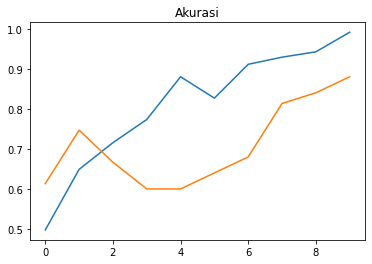

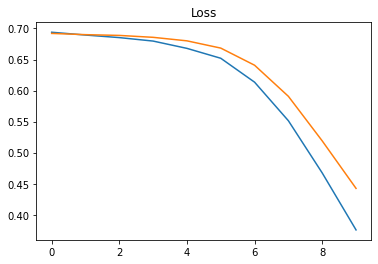

In [ ]:
plt.figure()
plt.title("Akurasi")
plt.plot(history.history["acc"])
plt.plot(history.history["val_acc"])

plt.figure()
plt.title("Loss")
plt.plot(history.history["loss"])
plt.plot(history.history["val_loss"])

plt.show()

### Prediksi Model

In [ ]:
contoh_review = ["jaringan <provider_name> sangat baik"]
prediksi = model.predict(contoh_review) # Probabilitas
prediksi.squeeze()  # diatas 0.5 berarti label 1 atau sentimen positif, begitu juga sebaliknya

array(0.5287976, dtype=float32)

# Multi-Label dan Multi-Class Sentimen Analysis
Analisis sentimen yang biasa kita lakukan merupakan klasifikasi multi-class, yang mana target atau output dari data merupakan salah satu dari kategori 2 class berbeda, positif dan negatif.

Multi-label berarti, output klasifikasi kita bisa lebih dari satu, seperti misalnya kita ingin melakukan prediksi sentimen. Namun, sentimen tadi ditujukan pada beberapa topik atau subjek seperti bahan bakar, mesin, harga, servis dll.

Seperti masalah yang akan kita hadapi nanti, kita memiliki data tentang review mobil, tiap review memiliki beberapa label dan masing-masing memiliki 3 class: netral, positif dan negatif. Kita disuruh untuk membuat model machine learning yang dapat memprediksi review ke output yang memiliki banyak label dan banyak class.

Kasus ini merupakan salah satu penerapan Natural Language Understanding, yang mana selain tahu tentang hubungan input dan output, komputer diharapkan untuk paham juga tentang apa yang ditulis atau dibicarakan.

## Load Data
Sumber data masih sama, hanya berbeda file

In [ ]:
train_df = pd.read_csv("/content/Data-NLP-Bahasa-Indonesia/review_mobil/train_preprocess.csv")
train_df.head()

,sentence,fuel,machine,others,part,price,service
0,Saya memakai Honda Jazz GK5 tahun 2014 ( pertama meluncur ) . Mobil nya bagus dan enak sesuai moto nya menyenangkan untuk dikendarai,neutral,neutral,positive,neutral,neutral,neutral
1,Avanza kenapa jadi boros bensin begini dah ah. Baru diisi sudah mau setengah saja .,negative,neutral,neutral,neutral,neutral,neutral
2,"saran ku dan pengalaman ku , mending beli mobil niaga L300 atau canter . irit dan bandel .",positive,positive,neutral,neutral,neutral,neutral
3,Dari segi harga juga pajero lebih mahal 30 jutaan dibanding fortuner,neutral,neutral,neutral,neutral,positive,neutral
4,Kalo menurut gw enak pajero si,neutral,neutral,positive,neutral,neutral,neutral


## Text Preprocessing
Jika sebelumnya kita menghilangkan beberapa tanda baca, sekarang kita akan menghilangkan semua tanda baca.

### Text Cleaning

In [ ]:
punctuations = string.punctuation

def punct2wspace(text):
    return re.sub(r"[{}]+".format(punctuations), " ", text)

def normalize_wspace(text):
    return re.sub(r"\s+", " ", text)

def casefolding(text):
    return text.lower()

In [ ]:
def preprocess_text(text):
    text = punct2wspace(text)
    text = normalize_wspace(text)
    text = casefolding(text)
    return text

train_df["cleaned_text"] = train_df["sentence"].apply(preprocess_text)
train_df.head()

,sentence,fuel,machine,others,part,price,service,cleaned_text
0,Saya memakai Honda Jazz GK5 tahun 2014 ( pertama meluncur ) . Mobil nya bagus dan enak sesuai moto nya menyenangkan untuk dikendarai,neutral,neutral,positive,neutral,neutral,neutral,saya memakai honda jazz gk5 tahun 2014 pertama meluncur mobil nya bagus dan enak sesuai moto nya menyenangkan untuk dikendarai
1,Avanza kenapa jadi boros bensin begini dah ah. Baru diisi sudah mau setengah saja .,negative,neutral,neutral,neutral,neutral,neutral,avanza kenapa jadi boros bensin begini dah ah baru diisi sudah mau setengah saja
2,"saran ku dan pengalaman ku , mending beli mobil niaga L300 atau canter . irit dan bandel .",positive,positive,neutral,neutral,neutral,neutral,saran ku dan pengalaman ku mending beli mobil niaga l300 atau canter irit dan bandel
3,Dari segi harga juga pajero lebih mahal 30 jutaan dibanding fortuner,neutral,neutral,neutral,neutral,positive,neutral,dari segi harga juga pajero lebih mahal 30 jutaan dibanding fortuner
4,Kalo menurut gw enak pajero si,neutral,neutral,positive,neutral,neutral,neutral,kalo menurut gw enak pajero si


### Dapatkan Text dan Label

In [ ]:
label_map = {"neutral": 0, "positive": 1, "negative": 2}
columns = ["fuel", "machine", "others", "part", "price", "service"]
target = train_df[columns].apply(lambda col: col.map(label_map), axis=0).to_numpy()
features_text = train_df["cleaned_text"]

In [ ]:
# Masukkan ke dalam format tf.Data
target_dataset = tf.data.Dataset.from_tensor_slices(target)
features_dataset = tf.data.Dataset.from_tensor_slices(features_text)

## Subword Tokenization
Berbeda dengan tokenisasi biasa, subword tokenization menggunakan subkata sebagai elemen dalam kosakata. Subword Tokenization dapat mengatasi masalah kata yang tidak diketahui (unknown word) sehingga baik digunakan untuk berbagai macam task NLP.

### Konfigurasi BERT Tokenizer

In [ ]:
vocab_size = 10000
bert_tokenizer_params = dict(lower_case=True)

bert_vocab_args = dict(
    # Ukuran kosakata
    vocab_size=vocab_size,
    # Token pesanan yang harus dimasukkan dalam kosa kata
    reserved_tokens={},
    # Argumen untuk `text.BertTokenizer`
    bert_tokenizer_params=bert_tokenizer_params,
    # Argumen untuk `wordpiece_vocab.wordpiece_tokenizer_learner_lib.learn`
    learn_params={},
)

### Buat Kosakata

In [ ]:
# review_vocab
review_vocab = bert_vocab.bert_vocab_from_dataset(
    features_dataset,
    **bert_vocab_args
)

In [ ]:
print(review_vocab[:10])
print(review_vocab[10:20])
print(review_vocab[100:110])
print(review_vocab[200:210])

['0', '1', '2', '3', '4', '5', '6', '7', '8', '9']
['a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j']
['sama', '##r', 'itu', 'pajero', '##0', '##ya', 'gak', 'ya', '##ga', '##p']
['mobilio', '##5', '##tas', '##us', 'dibawa', 'keluarga', 'kota', 'lama', 'new', 'sampai']


### Simpan Kosakata

In [ ]:
def write_vocab_file(filepath, vocab):
    with open(filepath, 'w') as f:
        for token in vocab:
            print(token, file=f)

In [ ]:
write_vocab_file("review_vocab.txt", review_vocab)

### Buat Tokenizer

In [ ]:
review_tokenizer = text.BertTokenizer("review_vocab.txt", **bert_tokenizer_params)

#### Melihat isi Data

In [ ]:
for examples in features_dataset.batch(3).take(1):
    for text in examples:
        print(text)

tf.Tensor(b'saya memakai honda jazz gk5 tahun 2014 pertama meluncur mobil nya bagus dan enak sesuai moto nya menyenangkan untuk dikendarai', shape=(), dtype=string)
tf.Tensor(b'avanza kenapa jadi boros bensin begini dah ah baru diisi sudah mau setengah saja ', shape=(), dtype=string)
tf.Tensor(b'saran ku dan pengalaman ku mending beli mobil niaga l300 atau canter irit dan bandel ', shape=(), dtype=string)


#### Tokenisasi

In [ ]:
token_batch = review_tokenizer.tokenize(examples)
token_batch = token_batch.merge_dims(-2, -1)
token_batch

<tf.RaggedTensor [[38, 22, 236, 116, 381, 51, 265, 16, 78, 201, 91, 2, 104, 380, 344, 25,
  127, 328, 22, 235, 163, 302, 214, 39, 35, 76, 37, 87, 27, 253, 329, 45,
  22, 85, 54, 85, 35, 22, 195, 141, 195, 75, 61, 55, 360]                ,
 [46, 332, 154, 174, 166, 11, 58, 225, 62, 45, 13, 73, 10, 53, 172, 41, 185,
  45, 82, 218, 27, 152, 325, 93]                                            ,
 [27, 126, 40, 198, 37, 410, 198, 266, 123, 39, 23, 45, 49, 108, 21, 416,
  231, 261, 12, 40, 144, 47, 37, 165]                                    ]>

#### Detokenisasi

In [ ]:
word = review_tokenizer.detokenize(token_batch)
tf.strings.reduce_join(word, separator=" ", axis=-1)

<tf.Tensor: shape=(3,), dtype=string, numpy=
array([b'saya memakai honda jazz gk5 tahun 2014 pertama meluncur mobil nya bagus dan enak sesuai moto nya menyenangkan untuk dikendarai',
       b'avanza kenapa jadi boros bensin begini dah ah baru diisi sudah mau setengah saja',
       b'saran ku dan pengalaman ku mending beli mobil niaga l300 atau canter irit dan bandel'],
      dtype=object)>

## Input Pipeline
Pembuatan pipeline dari input akan dibantu oleh tensorflow `tf.data.Dataset` API, yang dapat memproses data secara berurutan.

In [ ]:
# Gabungkan fitur dan target
review_dataset = tf.data.Dataset.zip((features_dataset, target_dataset))
review_dataset

<ZipDataset element_spec=(TensorSpec(shape=(), dtype=tf.string, name=None), TensorSpec(shape=(6,), dtype=tf.int64, name=None))>

In [ ]:
def tokenize_text(tensor, target):
    token_batch = review_tokenizer.tokenize(tensor)
    token_batch = token_batch.merge_dims(-2, -1)
    return token_batch.to_tensor(), target

def split_label(tensor, target):
    return tensor, {col: target[:, index] for index, col in enumerate(columns)}

review_dataset = (review_dataset.batch(32)
                                .prefetch(tf.data.AUTOTUNE)
                                .map(tokenize_text)
                                .map(split_label))

## Model Building: Neural Network
Pembuatan model masih menggunakan keras, namun pendekatan yang kita lakukan adalah functional API, sedangkan sebelumnya kita memakai sequential model.

Functional API memungkinkan kita untuk membuat struktur neural network yang lebih bervariasi, berbeda dengan struktur yang berurutan seperti sequential.

### Bangun Model

In [ ]:
embedding_dim = 64
n_class = 3

# Buat model dengan functional API
input_tensor = keras.Input(shape=(None,), dtype="int64")
x = keras.layers.Embedding(vocab_size, embedding_dim, mask_zero=True)(input_tensor)
x = keras.layers.LSTM(32)(x)
x = keras.layers.Dropout(0.5)(x)
x = keras.layers.Dense(16)(x)

fuel_output = keras.layers.Dense(n_class, activation="softmax", name="fuel")(x)
machine_output = keras.layers.Dense(n_class, activation="softmax", name="machine")(x)
others_output = keras.layers.Dense(n_class, activation="softmax", name="others")(x)
part_output = keras.layers.Dense(n_class, activation="softmax", name="part")(x)
price_output = keras.layers.Dense(n_class, activation="softmax", name="price")(x)
service_output = keras.layers.Dense(n_class, activation="softmax", name="service")(x)

outputs = [fuel_output, machine_output, others_output, part_output, price_output, service_output]

model = keras.Model(inputs=input_tensor, outputs={col: out for col, out in zip(columns, outputs)})

# Tentukan loss, optimizer dan metrik yang akan digunakan
model.compile(loss="sparse_categorical_crossentropy", 
              optimizer="adam",
              metrics=["acc"])

### Struktur Model

In [ ]:
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, None)]       0           []                               
                                                                                                  
 embedding_5 (Embedding)        (None, None, 64)     640000      ['input_2[0][0]']                
                                                                                                  
 lstm_7 (LSTM)                  (None, 32)           12416       ['embedding_5[0][0]']            
                                                                                                  
 dropout_4 (Dropout)            (None, 32)           0           ['lstm_7[0][0]']                 
                                                                                            

### Latih Model

In [ ]:
# Melatih model
history = model.fit(review_dataset, epochs=10)

Epoch 1/10
26/26 [==============================] - 8s 55ms/step - loss: 6.0377 - fuel_loss: 0.9514 - machine_loss: 0.9864 - others_loss: 1.0617 - part_loss: 1.1150 - price_loss: 0.9028 - service_loss: 1.0203 - fuel_acc: 0.7778 - machine_acc: 0.7173 - others_acc: 0.4531 - part_acc: 0.2086 - price_acc: 0.7926 - service_acc: 0.6741
Epoch 2/10
26/26 [==============================] - 1s 56ms/step - loss: 4.5073 - fuel_loss: 0.6091 - machine_loss: 0.7443 - others_loss: 0.8845 - part_loss: 1.0190 - price_loss: 0.6333 - service_loss: 0.6171 - fuel_acc: 0.8370 - machine_acc: 0.7827 - others_acc: 0.6272 - part_acc: 0.5272 - price_acc: 0.8321 - service_acc: 0.8506
Epoch 3/10
26/26 [==============================] - 1s 55ms/step - loss: 4.1225 - fuel_loss: 0.5454 - machine_loss: 0.6941 - others_loss: 0.8623 - part_loss: 0.8537 - price_loss: 0.5905 - service_loss: 0.5766 - fuel_acc: 0.8358 - machine_acc: 0.7840 - others_acc: 0.6432 - part_acc: 0.6988 - price_acc: 0.8309 - service_acc: 0.8519
Epoc

### Prediksi

In [ ]:
examples = tf.constant(["bahan bakar mobil avanza masih kurang keren"])
token = review_tokenizer.tokenize(examples)
token = token.merge_dims(-2, -1)
token = token.to_tensor()

model.predict(token)

{'fuel': array([[0.7186369 , 0.24966142, 0.03170165]], dtype=float32),
 'machine': array([[0.71628493, 0.25233042, 0.0313846 ]], dtype=float32),
 'others': array([[0.58306205, 0.38260263, 0.03433536]], dtype=float32),
 'part': array([[0.8418998 , 0.08556066, 0.07253959]], dtype=float32),
 'price': array([[0.8894462 , 0.08698163, 0.02357225]], dtype=float32),
 'service': array([[0.96959394, 0.01976297, 0.01064306]], dtype=float32)}

In [ ]:
{"neutral": 0, "positive": 1, "negative": 2}

{'negative': 2, 'neutral': 0, 'positive': 1}